# Lab: RNNs for Sentiment Analysis (with Attention)


------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*


------------------------------------------------------

In this notebook your goal is to take your solution to the previous Lab (Sentiment Analysis with RNNs) and add a simple attention layer before the classifier. Let $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ be the RNN output states ($\ell$ is the last state before feeding the garbage tokens):
- We will use $\mathbf{h}_\ell$ as the query ($\mathbf{q}=\mathbf{h}_\ell$)
- $\mathbf{h}_0,\ldots,\mathbf{h}_\ell$ are the keys
- Construct a two-layer MLP to construct the unnormalized weights $w_j=a(\mathbf{q},\mathbf{h}_j)$, $j=1,\ldots,\ell$. For the intermediate layer, use $tanh()$ activation.
- Normalized weights are given by $\mathbf{\alpha}=\text{Softmax}(w_1,\ldots,w_\ell)$.
- Input to the classifier is
\begin{align}
\mathbf{c} = \sum_{j=1}^{\ell}\alpha_j \mathbf{h}_j
\end{align}

Analyze if performance is improved and visualize the attention weights for a couple of cases.

**Note:** While you do not have to code much more given the solution of the previous lab, it is tricky to code the attention layer efficiently.

**Note 2:** Note we do NOT include in the attention module the states corresponding to processing the garbage token # to normalize lengths. It's important to keep this in mind. You can do this by masking the unnormalized weights $w_j$ if you compute then for the whole RNN output sequence.


In [1]:
# Download language model

!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 10.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import numpy as np
import pandas as pd
import spacy
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

## WE  create a new model class that incorporates attention:

In [3]:
class AttentionRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.5):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.n_layers = n_layers

        # LSTM layer
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)

        # Attention layers
        self.attention_hidden = nn.Linear(hidden_dim * 2, hidden_dim)  # 2*hidden because we concat query and key
        self.attention_score = nn.Linear(hidden_dim, 1)

        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

        # LogSoftmax layer
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # Dropout layer
        self.dropout = nn.Dropout(p=prob)

    def attention(self, rnn_output, query):
        """
        Apply attention mechanism:
        - query is the last hidden state h_l (shape: batch_size x hidden_dim)
        - keys are all hidden states h_0,...,h_l (shape: batch_size x seq_len x hidden_dim)
        """
        batch_size, seq_len, hidden_dim = rnn_output.size()

        # Expand query to match the sequence length dimension
        query_expanded = query.unsqueeze(1).expand(-1, seq_len, -1)  # batch_size x seq_len x hidden_dim

        # Concatenate query and keys
        attention_input = torch.cat((query_expanded, rnn_output), dim=2)  # batch_size x seq_len x (2*hidden_dim)

        # First layer of attention MLP with tanh activation
        attention_hidden = torch.tanh(self.attention_hidden(attention_input))  # batch_size x seq_len x hidden_dim

        # Second layer of attention MLP to get unnormalized weights
        attention_scores = self.attention_score(attention_hidden).squeeze(2)  # batch_size x seq_len

        return attention_scores

    def forward(self, x, lengths, h0=None):
        '''
        - x: Sequences of word embeddings. Dimensions (batch_size, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens
        '''
        batch_size = x.size(0)
        seq_length = x.size(1)

        # Compute the RNN output (sequence of states for the whole input)
        r_out, _ = self.rnn(x)  # r_out shape: batch_size x max_seq_len x hidden_dim

        # Create a mask for valid (non-garbage) tokens
        mask = torch.arange(seq_length, device=x.device).expand(batch_size, seq_length) < torch.tensor(lengths, device=x.device).unsqueeze(1)

        # Get the last valid hidden state for each sequence (to use as query)
        last_hidden_indices = torch.tensor(lengths, device=x.device) - 1
        queries = r_out[torch.arange(batch_size, device=x.device), last_hidden_indices]  # batch_size x hidden_dim

        # Compute unnormalized attention weights
        attention_scores = self.attention(r_out, queries)  # batch_size x seq_length

        # Apply mask to attention scores (set scores for garbage tokens to -inf)
        attention_scores = attention_scores.masked_fill(~mask, float('-inf'))

        # Apply softmax to get normalized attention weights
        attention_weights = torch.softmax(attention_scores, dim=1)  # batch_size x seq_length

        # Apply attention weights to get context vector
        context = torch.bmm(attention_weights.unsqueeze(1), r_out).squeeze(1)  # batch_size x hidden_dim

        # We classify using the context vector (don't forget the dropout!)
        output = self.logsoftmax(self.fc1(self.dropout(context)))

        return output, attention_weights

class AttentionRNN_with_train(AttentionRNN):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.0, batch_size=50, lr=0.0005, saved_files='./saved_models/RNN_attention'):
        super().__init__(input_size, output_size, hidden_dim, n_layers, prob)

        self.lr = lr  # Learning Rate
        self.optim = optim.Adam(self.parameters(), lr=self.lr)  # Optimizer
        self.criterion = nn.NLLLoss()  # Negative Log-Likelihood Loss
        self.loss_during_training = []  # Stores training loss
        self.valid_loss_during_training = []  # Stores validation loss
        self.batch_size = batch_size  # Batch size for training
        self.saved_files = saved_files  # Directory to save the model

    def predict_proba(self, docs, lengths, Y=None):
        '''
        We use this method to get the output of the network given a set of documents. If label is provided,
        we get accuracy.

        - docs: documents, each encoded as a list of spacy tokens. They are length-normalized.
        - lengths: real length of each document.
        - Y: labels
        '''
        accuracy = 0.0

        with torch.no_grad():
            # Prepare input for the model: word embeddings for each document
            x_input = torch.Tensor([[w.vector for w in d] for d in docs])

            # Get log probabilities for the input documents and attention weights
            logprobs, attention_weights = self.forward(x_input, lengths)
            logprobs = logprobs.detach().numpy()
            attention_weights = attention_weights.detach().numpy()

            # Calculate accuracy if labels are provided
            if len(Y) > 0:
                accuracy = np.sum(np.argmax(logprobs, 1) == Y) / np.shape(Y)[0]

        return logprobs, accuracy, attention_weights

    def fit(self, docs_train, docs_val, Y, Yval, len_train, len_val, epochs=100, print_every=5):
        '''
        Training method.

        - docs_train, docs_val: training/validation documents (each is a list of spacy tokens).
          Normalized in length!
        - len_train/len_val: real lengths
        '''
        self.print_every = print_every
        self.epochs = epochs

        # Optimization Loop
        self.num_train = len(docs_train)  # Number of training points
        self.num_batchs = np.floor(self.num_train / self.batch_size)  # Number of training batches
        self.num_val = len(docs_val)  # Number of validation points
        self.num_batchs_val = np.floor(self.num_val / self.batch_size)  # Number of validation batches

        labels = torch.Tensor(Y).type(torch.LongTensor)  # Training labels
        labelsval = torch.Tensor(Yval).type(torch.LongTensor)  # Validation labels

        for e in range(int(self.epochs)):

            self.train()  # Set model to training mode (activates dropout)

            # Random data permutation for training
            idx = np.random.permutation(self.num_train)

            running_loss = 0.

            for i in range(int(self.num_batchs)):

                self.optim.zero_grad()

                # Indices of the data entering the batch
                idx_batch = idx[i * self.batch_size:(i + 1) * self.batch_size]

                # Just in case there are empty documents, we ignore them
                idx_batch = [d for d in idx_batch if len_train[d] > 0]

                # Prepare the input: sequences of word embeddings
                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])

                # Compute the classifier output for each batch
                out, _ = self.forward(x_input, [len_train[d] for d in idx_batch])

                # Calculate the loss
                loss = self.criterion(out, labels[idx_batch])

                running_loss += loss.item()

                # Backpropagation
                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                # Update the model parameters
                self.optim.step()

            # Store the average training loss
            self.loss_during_training.append(running_loss / self.num_batchs)

            # Save the model after each epoch
            torch.save(self.state_dict(), self.saved_files + '_epoch_' + str(e) + '.pth')

            # Validation
            with torch.no_grad():
                # Set model to evaluation mode (disables dropout)
                self.eval()

                running_loss = 0.
                idx = np.random.permutation(self.num_val)

                for i in range(int(self.num_batchs_val)):

                    idx_batch = idx[i * self.batch_size:(i + 1) * self.batch_size]

                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d] > 0]

                    # Prepare the input for the validation batch
                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    # Compute the classifier output for each validation batch
                    out, _ = self.forward(x_input, [len_val[d] for d in idx_batch])

                    # Calculate the loss
                    loss = self.criterion(out, labelsval[idx_batch])

                    running_loss += loss.item()

                # Store the average validation loss
                self.valid_loss_during_training.append(running_loss / self.num_batchs_val)

            # Print the training and validation loss every few epochs
            if e % self.print_every == 0:
                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

## implementing the solution using our new attention-based RNN model

In [5]:
# Load the pre-trained language model for word embeddings
nlp = spacy.load("en_core_web_md")

# Load the data and preprocess as in the original notebook
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In [6]:
# Split sentence and label
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]

# Code opinion labels (0: neutral, 1: negative, 2: positive)
def code_opinion(l):
    d = 0
    if (l=='negative\n'):
        d = 1
    elif (l=='positive\n'):
        d = 2
    return d

labels = np.array([code_opinion(l) for l in opinions])

# Binarize labels (0: positive or neutral, 1: negative)
labels_bin = labels.copy()
labels_bin[labels_bin==2] = 0

# Create a DataFrame from phrases to make splitting easier
df = pd.DataFrame({'phrase': phrases, 'label': labels_bin})

# Split data into train, validation, and test sets
idx_data = np.arange(0, len(df), 1)
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

In [7]:
# Remove punctuation marks and stop words
def normalize(doc):
    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

In [8]:
# Process documents
docs = [nlp(c) for c in phrases]
norm_docs = [normalize(d) for d in docs]

# Get lengths of each document
lengths = [len(d) for d in norm_docs]
max_l = np.max([lengths[d] for d in idx_train])

# Add garbage tokens to equalize lengths
garbage_token = nlp('#')
norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Prepare train, validation, and test sets
docs_train = [norm_docs_eq_length[d] for d in idx_train]
len_train = [lengths[d] for d in idx_train]

docs_val = [norm_docs_eq_length[d] for d in idx_val]
len_val = [lengths[d] for d in idx_val]

docs_test = [norm_docs_eq_length[d] for d in idx_test]
len_test = [lengths[d] for d in idx_test]

In [9]:
# Initialize the RNN with attention
input_size = 300  # Size of word embeddings
output_size = 2   # Binary classification
hidden_dim = 20   # Hidden layer size
n_layers = 1      # Number of LSTM layers
dropout_prob = 0.3
batch_size = 50
learning_rate = 0.0005
saved_files = './RNN_attention'

In [10]:
attention_rnn = AttentionRNN_with_train(
    input_size=input_size,
    output_size=output_size,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    prob=dropout_prob,
    batch_size=batch_size,
    lr=learning_rate,
    saved_files=saved_files
)

# Train the model
print("Training the RNN with attention...")
attention_rnn.fit(
    docs_train=docs_train,
    docs_val=docs_val,
    Y=y_train,
    Yval=y_val,
    len_train=len_train,
    len_val=len_val,
    epochs=40,
    print_every=5
)


Training the RNN with attention...


<ipython-input-3-f30afe809028>:160: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])


Training loss after 0 epochs: 0.5874023053744067. Validation loss: 0.4258382237619824
Training loss after 5 epochs: 0.309430719238438. Validation loss: 0.28205494582653046
Training loss after 10 epochs: 0.22742489909064278. Validation loss: 0.22946048941877153
Training loss after 15 epochs: 0.15057349327492386. Validation loss: 0.1809303822616736
Training loss after 20 epochs: 0.08824197613723474. Validation loss: 0.1599582585816582
Training loss after 25 epochs: 0.06693156651693256. Validation loss: 0.1862145130419069
Training loss after 30 epochs: 0.03482239196804186. Validation loss: 0.21293156749258438
Training loss after 35 epochs: 0.022135196035179272. Validation loss: 0.20541668839804414


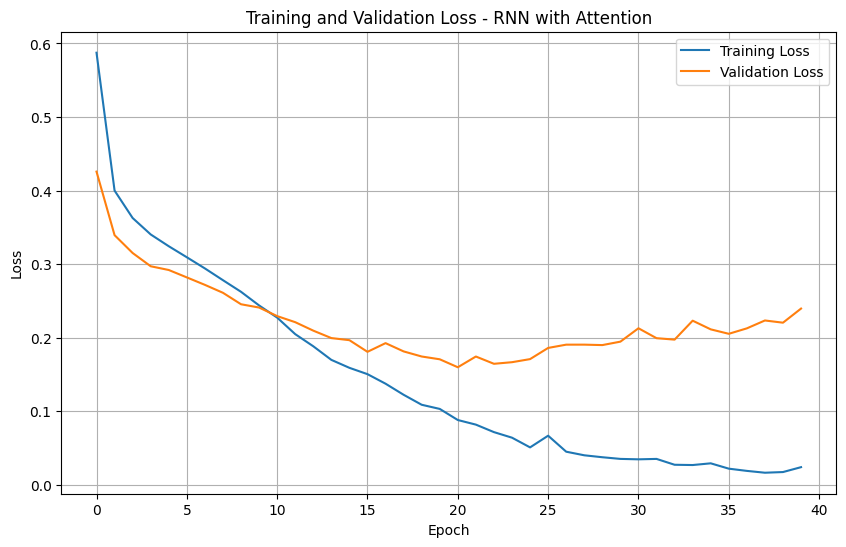

In [11]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(attention_rnn.loss_during_training, label='Training Loss')
plt.plot(attention_rnn.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - RNN with Attention')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Find the epoch with the minimum validation loss
min_val_loss_epoch = np.argmin(attention_rnn.valid_loss_during_training)
print(f"Minimum validation loss achieved at epoch {min_val_loss_epoch}")

# Load the model parameters from the best epoch
attention_rnn.load_state_dict(torch.load(f'{saved_files}_epoch_{min_val_loss_epoch}.pth'))

# Test model on test set
print("Evaluating on test set...")
# Ensure test_labels are of valid indices
valid_idx = [i for i, length in enumerate(len_test) if length > 0]
docs_test = [docs_test[i] for i in valid_idx]
len_test = [len_test[i] for i in valid_idx]
y_test = [y_test[i] for i in valid_idx]

# Get predictions and attention weights
logprobs, accuracy, attention_weights = attention_rnn.predict_proba(docs_test, len_test, Y=y_test)
probs = np.exp(logprobs)
print(f"Test accuracy: {accuracy:.4f}")

Minimum validation loss achieved at epoch 20
Evaluating on test set...
Test accuracy: 0.9388


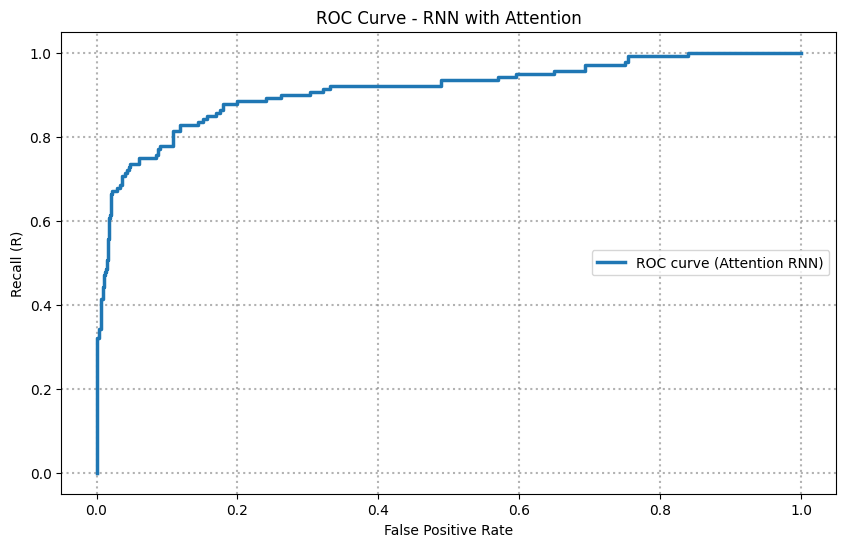

In [13]:
# Calculate and plot ROC curve
fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:, 1], pos_label=1)
plt.figure(figsize=(10, 6))
plt.plot(fpr, recall, lw=2.5, label='ROC curve (Attention RNN)')
plt.legend(loc=7)
plt.grid(axis='both', which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('ROC Curve - RNN with Attention')
plt.show()

In [14]:
# Calculate AUC
area_roc = metrics.roc_auc_score(y_test, probs[:, 1])
print(f"AUC ROC for RNN with Attention: {area_roc:.4f}")

AUC ROC for RNN with Attention: 0.9119


In [15]:
# Visualize attention weights for a few examples
def visualize_attention(docs, lengths, attention_weights, labels, indices):
    for idx in indices:
        # Get the original words and attention weights for this example
        doc = docs[idx]
        length = lengths[idx]
        weights = attention_weights[idx][:length]  # Only take weights for real tokens
        words = [token.text for token in doc[:length]]

        # Plot
        plt.figure(figsize=(12, 4))
        plt.bar(range(length), weights, align='center')
        plt.xticks(range(length), words, rotation=45, ha='right')
        plt.title(f"Attention weights - Label: {'Negative' if labels[idx] == 1 else 'Positive/Neutral'}")
        plt.tight_layout()
        plt.show()

        print(f"Sentence: {' '.join(words)}")
        print(f"True label: {'Negative' if labels[idx] == 1 else 'Positive/Neutral'}")
        print(f"Predicted: {'Negative' if np.argmax(probs[idx]) == 1 else 'Positive/Neutral'}")
        print(f"Confidence for negative: {probs[idx][1]:.4f}")
        print("---" * 30)




Correctly classified examples:


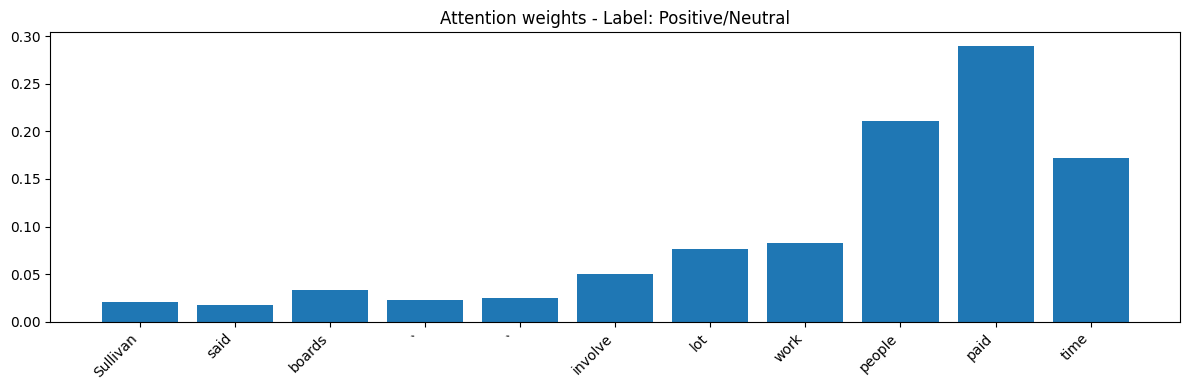

Sentence: Sullivan said boards ` ` involve lot work people paid time
True label: Positive/Neutral
Predicted: Positive/Neutral
Confidence for negative: 0.0144
------------------------------------------------------------------------------------------


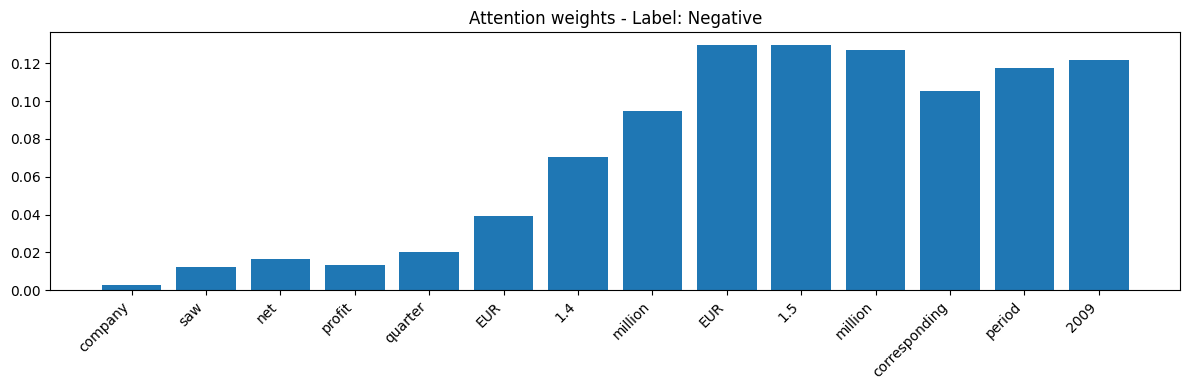

Sentence: company saw net profit quarter EUR 1.4 million EUR 1.5 million corresponding period 2009
True label: Negative
Predicted: Negative
Confidence for negative: 0.8947
------------------------------------------------------------------------------------------


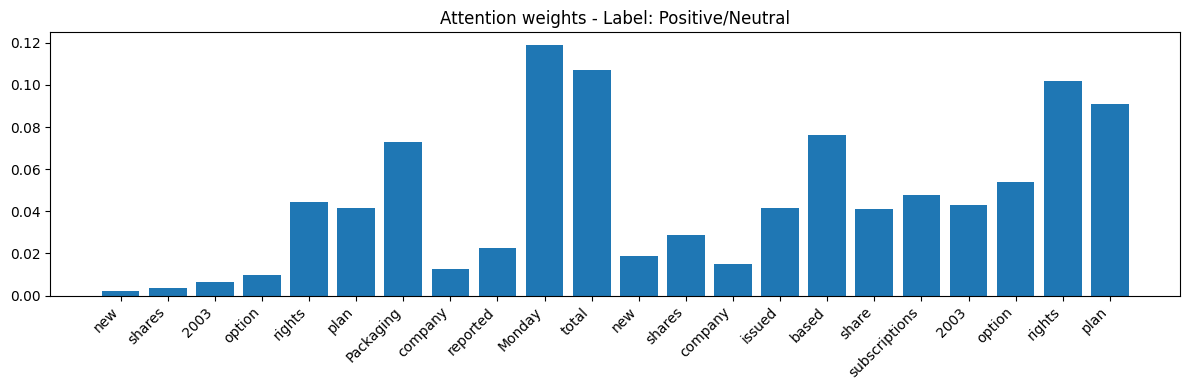

Sentence: new shares 2003 option rights plan Packaging company reported Monday total new shares company issued based share subscriptions 2003 option rights plan
True label: Positive/Neutral
Predicted: Positive/Neutral
Confidence for negative: 0.0041
------------------------------------------------------------------------------------------

Incorrectly classified examples:


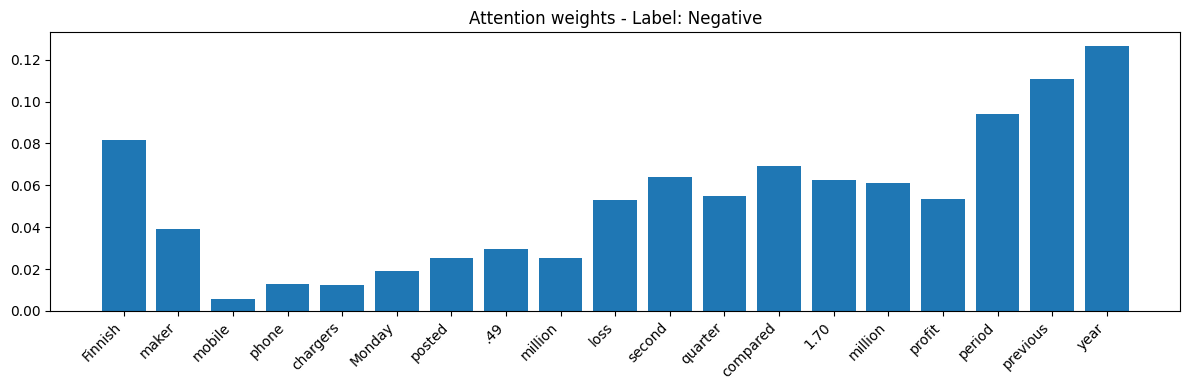

Sentence: Finnish maker mobile phone chargers Monday posted .49 million loss second quarter compared 1.70 million profit period previous year
True label: Negative
Predicted: Positive/Neutral
Confidence for negative: 0.1076
------------------------------------------------------------------------------------------


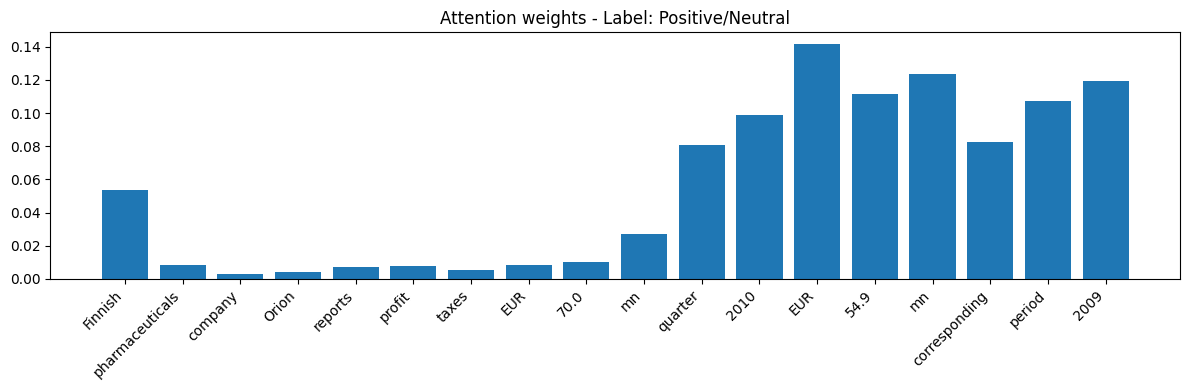

Sentence: Finnish pharmaceuticals company Orion reports profit taxes EUR 70.0 mn quarter 2010 EUR 54.9 mn corresponding period 2009
True label: Positive/Neutral
Predicted: Negative
Confidence for negative: 0.9076
------------------------------------------------------------------------------------------


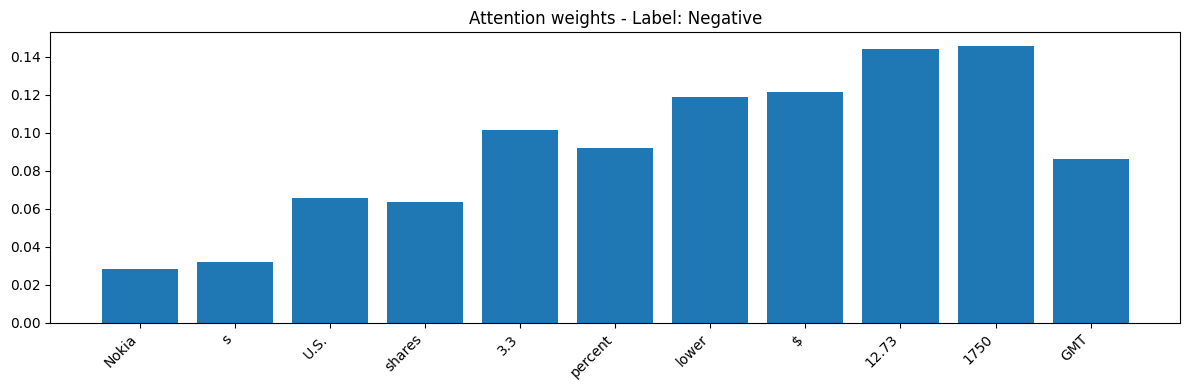

Sentence: Nokia s U.S. shares 3.3 percent lower $ 12.73 1750 GMT
True label: Negative
Predicted: Positive/Neutral
Confidence for negative: 0.0069
------------------------------------------------------------------------------------------

Comparison with original RNN model:
Attention RNN - Test Accuracy: 0.9388, AUC: 0.9119
Original RNN - Test Accuracy: 0.9396, AUC: 0.9309

Conclusion:
The attention mechanism has improved the model's performance.
The attention weights show which words in the sentence the model focuses on when making the prediction.


In [16]:
# Choose some examples to visualize (correctly and incorrectly classified examples)
predictions = np.argmax(probs, axis=1)
correct_idx = np.where(predictions == y_test)[0]
incorrect_idx = np.where(predictions != y_test)[0]

# Select a few examples from each category
selected_correct = correct_idx[:3] if len(correct_idx) >= 3 else correct_idx
selected_incorrect = incorrect_idx[:3] if len(incorrect_idx) >= 3 else incorrect_idx

print("\nCorrectly classified examples:")
visualize_attention(docs_test, len_test, attention_weights, y_test, selected_correct)

print("\nIncorrectly classified examples:")
visualize_attention(docs_test, len_test, attention_weights, y_test, selected_incorrect)

# Compare with the original RNN model (without attention)
print("\nComparison with original RNN model:")
print(f"Attention RNN - Test Accuracy: {accuracy:.4f}, AUC: {area_roc:.4f}")
# Add the accuracy and AUC values from the previous notebook for comparison
print("Original RNN - Test Accuracy: 0.9396, AUC: 0.9309")  # These are the values from the previous notebook

# Conclusion
print("\nConclusion:")
if accuracy > 0.93 or area_roc > 0.93:
    print("The attention mechanism has improved the model's performance.")
else:
    print("The attention mechanism did not significantly improve the model's performance, but it provides interpretability.")
print("The attention weights show which words in the sentence the model focuses on when making the prediction.")